In [15]:
#%%
import math
import numpy as np

#%pip install geopandas          #use this method to install package on the go
#%pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
#%pip install matplotlib

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
#%pip install shapely

from shapely.geometry import Polygon
from shapely.geometry import box



#%pip install folium
import folium

#%pip install rasterio
import rasterio
from rasterio.plot import show
import rasterio.plot



<AxesSubplot:>

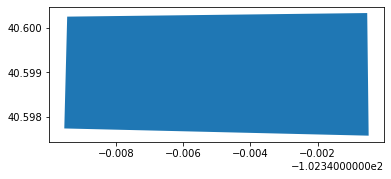

In [4]:

#import utm

polygon_points=[[-102.349451,40.600256],[-102.349537,40.597730],[-102.340482, 40.597567],[-102.340525,40.600337],[-102.349451,40.600256]]
#zone=utm.from_latlon(polygon_points[0][1],polygon_points[0][0])


polygon_geom = Polygon(polygon_points)
polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[polygon_geom]) 
#The below line can be used for new polygons to save the polygon as a zipped shape file
#polygon.to_file(filename='D:\OneDrive - purdue.edu\AutomatingAgFieldTrials\Fall2024\jvkField2_1.zip', driver="ESRI Shapefile")
polygon.plot()

In [6]:
map = folium.Map(location=[polygon_points[0][1],polygon_points[0][0]], tiles="CartoDB Positron", zoom_start=10)
map


In [7]:
#%%
for _, r in polygon.iterrows():
    #without simplifying the representation of each borough, the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry'])
    
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    print(geo_j)
    geo_j = folium.GeoJson(data=geo_j,style_function=lambda x: {"fillColor": "orange"})
    geo_j.add_to(map)
    

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-102.349451, 40.600256], [-102.349537, 40.59773], [-102.340482, 40.597567], [-102.340525, 40.600337], [-102.349451, 40.600256]]]}, "bbox": [-102.349537, 40.597567, -102.340482, 40.600337]}], "bbox": [-102.349537, 40.597567, -102.340482, 40.600337]}


In [8]:
map

EPSG:26913


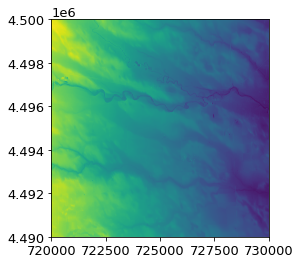

<AxesSubplot:>

In [46]:
output_tif=r"/Users/jhasneha/Documents/DOEjha/jvkField2/JVK_shared/TWI_workingFolder/JVKF2_USGS_1M_13_x72y450_CO_NESEColorado_2019_C20.tif"
#output_tif=r"D:\OneDrive - purdue.edu\AutomatingAgFieldTrials\Fall2024\jvkField2\JVKF2_USGS_1M_13_x72y450_CO_NESEColorado_2019_C20.tif"

imgUSGS = rasterio.open(output_tif)
print(imgUSGS.crs)
show(imgUSGS)


In [11]:
lidarfile=imgUSGS
jvkF2LidarfileCRS=polygon.to_crs(lidarfile.crs)
#the below line can changed to generalize the following lines by substituting the field of interest variable here
FieldOfInterest=jvkF2LidarfileCRS

/Users/jhasneha/.pyenv/versions/3.9.5/lib/python3.9/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(4497429.742524607, 4497842.185650435)

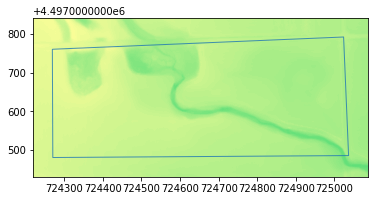

In [12]:



ax = FieldOfInterest.plot( column="name",color="None", alpha=0.8, cmap="tab10")
# AcreMultipolygon2022.apply(lambda x: ax.annotate(text=x['Name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
rasterio.plot.show(lidarfile,ax=ax, cmap="terrain")
# ctx.add_basemap(ax,
#                 crs=lidarfile.crs,
#                 source=ctx.providers.USGS.USImagery
#                )
plt.xlim([float(FieldOfInterest.bounds.minx)-50, float(FieldOfInterest.bounds.maxx)+50])
plt.ylim([float(FieldOfInterest.bounds.miny)-50, float(FieldOfInterest.bounds.maxy)+50])


In [13]:
print(lidarfile.count)
horizontal_resolution=(lidarfile.bounds.right- lidarfile.bounds.left)/lidarfile.width
print("resolution of lidar file", horizontal_resolution)
vertical_resolution=(lidarfile.bounds.top- lidarfile.bounds.bottom)/lidarfile.height
print("resolution of lidar file", vertical_resolution)


1
resolution of lidar file 1.0
resolution of lidar file 1.0


calculated resolutions for lidar data are:  1.0 5.0 10.0
Field Dimensions are:  0    767.995708
dtype: float64 0    312.443126
dtype: float64
Area of field is:  0    239954.979764
dtype: float64


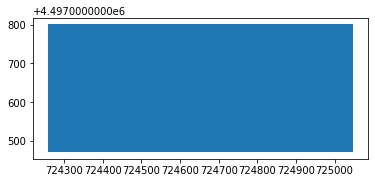

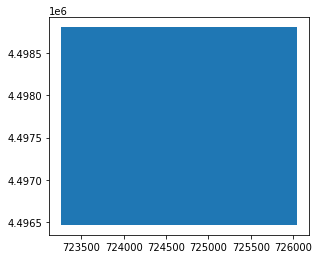

In [16]:

fieldShapeUTM=FieldOfInterest
step=horizontal_resolution  #1 meter for uSGS and 2.5feet for jinha 
stepLowRes=step*5   #step*5        #step*7  #5 meters creates 150 point for 3.2km length acre field can also use array size to calculate distance
stepLowerRes=step*10 #step*10    #step*13  #10 meters creates 150 point for 3.2km length acre field can also use array size to calculate distance
print("calculated resolutions for lidar data are: ", step,stepLowRes,stepLowerRes)

bboxfieldShapeUTM=float(fieldShapeUTM.bounds.minx-(stepLowerRes)),float(fieldShapeUTM.bounds.miny-(stepLowerRes)),float(fieldShapeUTM.bounds.maxx+(stepLowerRes)),float(fieldShapeUTM.bounds.maxy+(stepLowerRes))
clipper = box(bboxfieldShapeUTM[0],bboxfieldShapeUTM[1],bboxfieldShapeUTM[2],bboxfieldShapeUTM[3])
fieldClipper = gpd.GeoDataFrame(index=[0], crs=lidarfile.crs, geometry=[clipper])
fieldClipper.plot()
#bigger buffer block for the field to be plotted in contextily
buffer = box(bboxfieldShapeUTM[0]-1000,bboxfieldShapeUTM[1]-1000,bboxfieldShapeUTM[2]+1000,bboxfieldShapeUTM[3]+1000)
fieldbuffer = gpd.GeoDataFrame(index=[0], crs=lidarfile.crs, geometry=[buffer])
fieldbuffer.plot()


Xwidth=fieldShapeUTM.bounds.maxx-fieldShapeUTM.bounds.minx
Ylength=fieldShapeUTM.bounds.maxy-fieldShapeUTM.bounds.miny
Areaoffield=Xwidth*Ylength
print("Field Dimensions are: ",Xwidth,Ylength)
print("Area of field is: ",Areaoffield)

<AxesSubplot:>

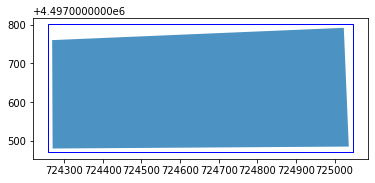

In [17]:


afax = FieldOfInterest.plot(  alpha=0.8, cmap="tab10")
fieldClipper.plot(ax=afax,color="None",edgecolor="blue")
#fieldbuffer.plot(ax=afax,color="None",edgecolor="black")



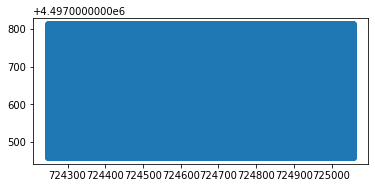

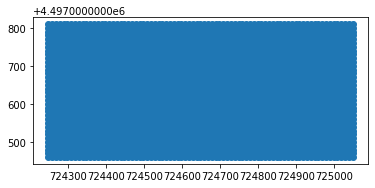

In [18]:
#the below code is converted into module in the full length program to shorten the length of the file. this works well.
xmin,ymin= float(fieldShapeUTM.bounds.minx),float(fieldShapeUTM.bounds.miny)
xmax,ymax= float(fieldShapeUTM.bounds.maxx),float(fieldShapeUTM.bounds.maxy)
xmin=xmin-(stepLowerRes*2)
ymin=ymin-(stepLowerRes*2)
xmax=xmax+(stepLowerRes*2)
ymax=ymax+(stepLowerRes*2)
""" 1m/2.5m resolution aspect calculation for visualization"""

xcoordsHighRes = [i for i in np.arange(xmin, xmax, step)]
ycoordsHighRes = [i for i in np.arange(ymin, ymax, step)]

pointcoords = np.array(np.meshgrid(xcoordsHighRes, ycoordsHighRes)).T.reshape(-1,2) #A 2D array like [[x1,y1], [x1,y2], ...
points = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])

grid = gpd.GeoSeries(points,crs=lidarfile.crs)
grid.plot()
ptsgdfHighRes= gpd.GeoDataFrame(geometry=gpd.GeoSeries(grid))

""" low resolution aspect calculation for visualization"""
# xmin, ymin, xmax, ymax = minx, miny, maxx, maxy

xcoordsLowRes = [i for i in np.arange(xmin, xmax, stepLowRes)]
ycoordsLowRes = [i for i in np.arange(ymin, ymax, stepLowRes)]

pointcoordsLowRes = np.array(np.meshgrid(xcoordsLowRes, ycoordsLowRes)).T.reshape(-1,2) #A 2D array like [[x1,y1], [x1,y2], ...
pointsLowRes = gpd.points_from_xy(x=pointcoordsLowRes[:,0], y=pointcoordsLowRes[:,1])
gridLowRes = gpd.GeoSeries(pointsLowRes, crs=lidarfile.crs)
ptsgdfLowRes= gpd.GeoDataFrame(geometry=gpd.GeoSeries(gridLowRes))
""" lower resolution for aspect calculation for visualization"""
# xmin, ymin, xmax, ymax = minx, miny, maxx, maxy

xcoordsLowerRes = [i for i in np.arange(xmin, xmax, stepLowerRes)]
ycoordsLowerRes = [i for i in np.arange(ymin, ymax, stepLowerRes)]

pointcoordsLowerRes = np.array(np.meshgrid(xcoordsLowerRes, ycoordsLowerRes)).T.reshape(-1,2) #A 2D array like [[x1,y1], [x1,y2], ...
pointsLowerRes = gpd.points_from_xy(x=pointcoordsLowerRes[:,0], y=pointcoordsLowerRes[:,1])
gridLowerRes = gpd.GeoSeries(pointsLowerRes, crs=lidarfile.crs)
ptsgdfLowerRes= gpd.GeoDataFrame(geometry=gpd.GeoSeries(gridLowerRes))
gridLowerRes.plot()
coord_listHighRes = [(x,y) for x,y in zip(ptsgdfHighRes["geometry"].x , ptsgdfHighRes["geometry"].y)]

coord_listLowRes = [(x,y) for x,y in zip(ptsgdfLowRes["geometry"].x , ptsgdfLowRes["geometry"].y)]

coord_listLowerRes = [(x,y) for x,y in zip(ptsgdfLowerRes["geometry"].x , ptsgdfLowerRes["geometry"].y)]
""" HIGH resolution aspect and slope calculation for visualization"""
ptsgdfHighRes["elevation"]= [x for x in lidarfile.sample(coord_listHighRes)]
ptsgdfHighRes["elevation(m)"]=ptsgdfHighRes["elevation"].astype(float)#*0.3048 #convert USfoot to m for jinha data
xHighRes,yHighRes=len(xcoordsHighRes),len(ycoordsHighRes)
elevationArray=ptsgdfHighRes["elevation(m)"].values.reshape(xHighRes, yHighRes)


#length from len(xcoords) and len(ycoords)
dxHighRes,dyHighRes=np.gradient(elevationArray)
slope = np.sqrt(dxHighRes**2 + dyHighRes**2)
ptsgdfHighRes["slope"]=slope.flatten()
ptsgdfHighRes["dxHighRes"]=dxHighRes.flatten()
ptsgdfHighRes["dyHighRes"]=dyHighRes.flatten()


dxHighRes,dyHighRes = np.gradient(elevationArray)
aspect=np.arctan2(-dyHighRes, dxHighRes)
ptsgdfHighRes["aspect"]=aspect.flatten()


""" low resolution aspect and slope calculation for visualization"""
ptsgdfLowRes["elevation"]= [x for x in lidarfile.sample(coord_listLowRes)]
ptsgdfLowRes["elevation(m)"]=ptsgdfLowRes["elevation"].astype(float)#*0.3048 #convert USfoot to m for jinha data
xLowRes,yLowRes=len(xcoordsLowRes),len(ycoordsLowRes)
elevationArrayLowRes=ptsgdfLowRes["elevation(m)"].values.reshape(xLowRes,yLowRes)


#length from len(xcoords) and len(ycoords)
dxLowRes,dyLowRes=np.gradient(elevationArrayLowRes)
slopeLowRes = np.sqrt(dxLowRes**2 + dyLowRes**2)
ptsgdfLowRes["slope"]=slopeLowRes.flatten()
ptsgdfLowRes["dxLowRes"]=dxLowRes.flatten()
ptsgdfLowRes["dyLowRes"]=dyLowRes.flatten()


dxLowRes, dyLowRes = np.gradient(elevationArrayLowRes)
aspectLowRes=np.arctan2(-dyLowRes, dxLowRes)
ptsgdfLowRes["aspect"]=aspectLowRes.flatten()


""" Much lower resolution aspect and slope calculation for visualization of aspect"""

ptsgdfLowerRes["elevation"]= [x for x in lidarfile.sample(coord_listLowerRes)]
ptsgdfLowerRes["elevation(m)"]=ptsgdfLowerRes["elevation"].astype(float)#*0.3048 #convert USfoot to m for jinha data
xLowerRes,yLowerRes=len(xcoordsLowerRes),len(ycoordsLowerRes)
elevationArrayLowerRes=ptsgdfLowerRes["elevation(m)"].values.reshape(xLowerRes,yLowerRes)
#length from len(xcoords) and len(ycoords)
dxLowerRes,dyLowerRes=np.gradient(elevationArrayLowerRes)
slopeLowerRes = np.sqrt(dxLowerRes**2 + dyLowerRes**2)
ptsgdfLowerRes["slope"]=slopeLowerRes.flatten()
ptsgdfLowerRes["dxLowerRes"]=dxLowerRes.flatten()
ptsgdfLowerRes["dyLowerRes"]=dyLowerRes.flatten()
dxLowerRes, dyLowerRes = np.gradient(elevationArrayLowerRes)
aspectLowerRes=np.arctan2(-dyLowerRes, dxLowerRes)
ptsgdfLowerRes["aspect"]=aspectLowerRes.flatten()
ptsgdfLowRes_clipped=gpd.clip(ptsgdfLowRes,fieldClipper)
ptsgdfLowerRes_clipped=gpd.clip(ptsgdfLowerRes,fieldClipper)
ptsgdfHighRes_clipped=gpd.clip(ptsgdfHighRes, fieldClipper)
    # return(ptsgdfHighRes_clipped,ptsgdfLowRes_clipped,ptsgdfLowerRes_clipped, elevationArrayLowRes)
imgAcreMergedUSGSVectorHighRes=ptsgdfHighRes.copy()
imgAcreMergedUSGSVectorLowRes= ptsgdfLowRes.copy()
imgAcreMergedUSGSVectorLowerRes=ptsgdfLowerRes.copy()



In [19]:
def cmapElevationBinsSlopeAspectVisualization(plotDestinationPath,bins,datasource,ptsgdfHighRes_clipped,ptsgdfLowerRes_clipped):
    import contextily as ctx
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import os
    hfont = {'fontname':'Times New Roman'}
    plt.rcParams['font.size'] = 13
    # plt.rcParams['font.sans-serif']='Gill Sans'
    # fig, myax = plt.subplots(figsize=(6, 2))

    fieldname="JVK_Plot2"
    colors_land = plt.cm.nipy_spectral(np.linspace(0.40, 0.9, bins+1))

    terrain_map = colors.LinearSegmentedColormap.from_list(
        'terrain_map', colors_land)

    bounds = np.linspace(ptsgdfHighRes_clipped["elevation(m)"].min(), ptsgdfHighRes_clipped["elevation(m)"].max(), bins+1)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

    gdf=ptsgdfHighRes_clipped.copy()
    gdf_aspect=ptsgdfLowerRes_clipped.copy()
    myax = gdf.plot(column=gdf["elevation(m)"], alpha=1,norm=norm,  markersize=0.5, cmap=terrain_map, legend=True, legend_kwds={"label": "Lidar elevation (m)", "fmt":"%.1f","orientation": "vertical",'shrink':0.4, 'aspect':30})
    
    X= gdf_aspect['geometry'].x
    Y = gdf_aspect['geometry'].y
    U = np.cos(gdf_aspect['aspect']) #this is correct because the arctan function converts the gradient x and y values its angle angle
    V = np.sin(gdf_aspect['aspect'])
    uvis=U*(np.log(gdf_aspect['slope']+1)/np.log(2))
    vvis=V*(np.log(gdf_aspect['slope']+1)/np.log(2))
    uvisA= uvis*(100/gdf_aspect['slope'].max())
    vvisA= vvis*(100/gdf_aspect['slope'].max())
    # ax1=myax
    q=myax.quiver(X,Y,uvisA,vvisA)
    myax.quiverkey(q,5, 5.4, 100,label= 'Negative Gradient', labelpos='E',
                   coordinates='inches')
    fieldShapeUTM.plot(ax=myax, color="None", edgecolor="blue")
    # myax.annotate("Purdue ACRE", xy=(0.8, 0.01), xycoords='axes fraction',fontsize=14, **hfont)

    # plt.title("Slope and aspect visualization with "+str(bins)+" elevation zones (hist bins) in \n "+fieldname+ " at Purdue ACRE",fontsize=14, **hfont)
    plt.title("Elevation, Slope and aspect visualization with "+str(bins)+" bins.",fontsize=14, **hfont)

    # AcreMultipolygon2022UTM=AcreMultipolygon2022.to_crs(fieldShapeUTM.crs)
    fieldbuffer.plot(ax=myax, color="None",edgecolor="gray",  alpha=0.2)
    ctx.add_basemap(myax,
                    # crs=AcreMultipolygon2022UTM.crs,
                    crs=fieldShapeUTM.crs,
                    source=ctx.providers.USGS.USImagery
                )
    plt.xlim([float(fieldShapeUTM.bounds.minx)-160, float(fieldShapeUTM.bounds.maxx)+160])
    plt.ylim([float(fieldShapeUTM.bounds.miny)-160, float(fieldShapeUTM.bounds.maxy)+160])  
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
    plotname1=datasource+"_Slope_Aspect_visualization_"+str(bins)+"_bins_"+fieldname
    outputPath=plotDestinationPath
    SavePath=os.path.join(outputPath,plotname1)
    #plt.savefig(SavePath, dpi=600,bbox_inches = 'tight')
    plt.show()
    fighist, histax = plt.subplots(1,2,figsize=(6.4, 4.8),sharey=True,tight_layout=True)
    
   
    # histax.hist(ptsgdfHighRes_clipped[hist_var], bins=bins, edgecolor="black", color="#69b3a2", alpha=0.3)
    histax[0].hist(ptsgdfHighRes_clipped["slope"], bins=bins,edgecolor="black", color="darkmagenta", alpha=0.3)
    histax[1].hist(ptsgdfHighRes_clipped["elevation(m)"], bins=bins,edgecolor="black", color="sienna", alpha=0.3)

    histax[0].grid(which='major', color='gray', linestyle=':', linewidth=0.5)
    histax[1].grid(which='major', color='gray', linestyle=':', linewidth=0.5)
    
    histax[0].set_xlabel("Slope" , fontsize=14, **hfont)
    histax[1].set_xlabel("Elevation(m)", fontsize=14,**hfont)
    
    histax[0].tick_params(which='major', labelsize=12)
    histax[1].tick_params(which='major', labelsize=12)

    plt.suptitle("Histograms of Slope and Elevation with "+str(bins)+" bins \n in Purdue Acre Field 57", ha="center", fontsize=14,  **hfont)

    fighist.supylabel("Count", fontsize=14,**hfont)
    
    # # axvline: axis vertical line
    histax[0].axvline(ptsgdfHighRes_clipped["slope"].median(), color="red", ls="--", label="Median ")
    histax[0].axvline(ptsgdfHighRes_clipped["slope"].mean(), color="blue", ls=":", label="Mean ")
    histax[1].axvline(ptsgdfHighRes_clipped["elevation(m)"].median(), color="red", ls="--", label="Median ")
    histax[1].axvline(ptsgdfHighRes_clipped["elevation(m)"].mean(), color="blue", ls=":", label="Mean ")

    
    plt.legend(prop={'size': 12,'family':'Times new Roman'})
    plotname2=datasource+"_HistogramsEle_Slope_"+ fieldname+"_"+str(bins)+"_bins"
    outputPath=plotDestinationPath
    SavePathhist=os.path.join(outputPath,plotname2)
    #plt.savefig(SavePathhist, dpi=300,bbox_inches = 'tight')
    plt.show()


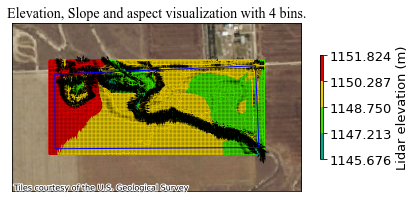

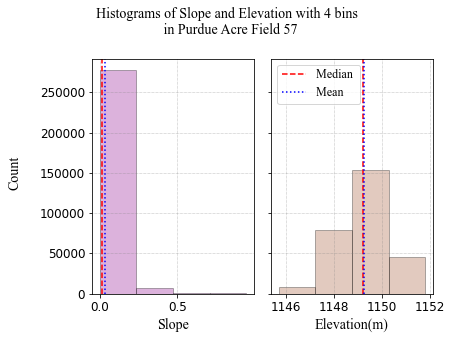

In [20]:
#the path to the destination folders hould be changed here , 
plotDestinationPath=r"/Users/jhasneha/Documents/DOEjha/jvkField2/JVK_shared"
#plotDestinationPath=r"D:\OneDrive - purdue.edu\AutomatingAgFieldTrials\Fall2024\jvkField2\plots"
binsList=[4]
for bins in binsList:
    cmapElevationBinsSlopeAspectVisualization(plotDestinationPath,bins,"USGS",imgAcreMergedUSGSVectorHighRes,imgAcreMergedUSGSVectorLowRes)


In [21]:
resDict={"imgAcreMergedUSGSVectorLowRes":stepLowRes,"imgAcreMergedUSGSVectorLowerRes":stepLowerRes,"imgAcreMergedUSGSVectorHighRes":step}
elevationArrayDict={"imgAcreMergedUSGSVectorLowRes":elevationArrayLowRes,"imgAcreMergedUSGSVectorLowerRes":elevationArrayLowerRes,"imgAcreMergedUSGSVectorHighRes":elevationArray}
shapeLowRes=(xLowRes,yLowRes) 
shapeLowerRes=(xLowerRes,yLowerRes)
shapeHighRes=(xHighRes,yHighRes)
shapeDict={"imgAcreMergedUSGSVectorLowRes":shapeLowRes,"imgAcreMergedUSGSVectorLowerRes":shapeLowerRes,"imgAcreMergedUSGSVectorHighRes":shapeHighRes}


In [22]:
elevation_array = np.array([
    [1130, 1125, 1137, 1132],
    [1131, 1127, 1148, 1136],
    [1134, 1129, 1133, 1135],
    [1131, 1141, 1129, 1125],
    [1133, 1144, 1132, 1127]
])
n,m = elevation_array.shape
print("the shape of elevation array is: ",n,m)
for i in range(n-2, 0, -1):
    for j in range(1, m-1, 1):
        print("the elevation is: ",i,j,elevation_array[i,j])

the shape of elevation array is:  5 4
the elevation is:  3 1 1141
the elevation is:  3 2 1129
the elevation is:  2 1 1129
the elevation is:  2 2 1133
the elevation is:  1 1 1127
the elevation is:  1 2 1148


## TWI Calculations start from here

In [36]:
import numpy as np


def calculateDownwardSlope(elevation_array, cell_size):
    import math
    n, m = elevation_array.shape
    downward_Slope_array = np.zeros((n, m))
    
    for row in range(1, n-1,1): 
        for col in range(1, m-1,1):
            downward_slopes = []
    # Calculate slopes and contributing area for the current cell
            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                # Boundary check: Ensure i + di and j + dj are within bounds
                ni, nj = row + di, col + dj
                if ni < 0 or ni > n or nj < 0 or nj > m:
                    print("out of bounds 2")
                    continue  # Skip if neighbor is out of bounds

                neighbor_elevation = elevation_array[ni, nj]
                distance = cell_size
                center_elevation=elevation_array[row, col]
                slope = (center_elevation - neighbor_elevation) / distance
                #print("the slope is: ",slope)
                # Accumulate flow from higher cells
                if slope > 0:
                    downward_slopes.append(abs(slope))
                #print(f"the downward slope at{row,col} is: ",len(downward_slopes))
    # Total upslope magnitude and contributing area calculation
            downward_Slope_array[row,col] = np.round(np.sum(downward_slopes),3)

            #print("the total upslope contribution is: ",Static_contributing_area_array[row,col])
    return downward_Slope_array



def propagate_flagging_With_Slope(elevation_array, start_cell, cell_size):
    """
    Propagate the flagging process for connected cells with higher elevation.
    """
    rows, cols = elevation_array.shape
    #print("the rows and cols are: ",rows,cols)
    flagged_array = np.zeros_like(elevation_array, dtype=float)
    queue = [start_cell]  # Initialize queue with the start cell
    flagged_array[start_cell] = 1.0
    downward_Slope_array=calculateDownwardSlope(elevation_array, cell_size)
    # plt.imshow(downward_Slope_array)
    # plt.colorbar()
    # Define the offsets for orthogonal neighbors
    offsets = [
        (-1, 0),  # Top
        (0, -1), (0, 1),  # Left and Right
        (1, 0)   # Bottom
    ]
    """Perform a breadth-first search to propagate flagging, starting from the first cell. The queue is used to store the cells 
    flagged as higher elevation in the order they were visited. This is useful for avoiding infinite looping along with the not flagged_array[ni,nj] condition ensures 
    that the neighbor cell has not been flagged before. This stops the algorith to accept the center pixel again. This is important to avoid infinite 
    looping due to center pixels in the search process."""

    while queue:
        current_cell = queue.pop(0) 
        i, j = current_cell
        for dx, dy in offsets:
            ni, nj = i + dx, j + dy

            # Check if the neighbor is within bounds and has not been flagged
            if 0 < ni < rows-1 and 0 < nj < cols-1 and flagged_array[ni, nj]<0.001: # Check if the neighbor is within bounds not i, j instead it is ni, nj
            #if 0 <= ni < rows and 0 <= nj < cols and not flagged_array[ni, nj]: #both are correct but this includes the calculation including the padding cells
                #print(f"the ni and nj for {i,j} are: ",ni,nj)
                # Check if the neighbor has a higher elevation
                if elevation_array[ni, nj] > elevation_array[i, j]:
                    slope = (elevation_array[i, j] - elevation_array[ni, nj]) / cell_size
                    #print("the flagged array at ",ni,nj," is: ",flagged_array[ni, nj])
                    weightslope=abs(slope)/downward_Slope_array[ni,nj]
                    flagged_array[ni, nj] = max(np.round(weightslope,3),0.001)
                    #print(f"flagged array at {i,j},{ni,nj} is: ",flagged_array[ni, nj])

                    queue.append((ni, nj))

    return flagged_array



def Calculate_TWI_extendedSlope(elevation_array, cell_size):
    """
    the implementation of flagging with weighted slope for each cell using iteration.
    """
    import math
    elevation_array=np.round(elevation_array,1)
    rows, cols = elevation_array.shape
    weightSlopeArray=np.zeros_like(elevation_array, dtype=float) # holds the weghted slope of the contributing cells for the current pixel
    average_slope_array = np.zeros_like(elevation_array, dtype=float) # holds the avrage slope of current pixel for TWI denominator
    Twi_array=np.zeros_like(elevation_array, dtype=float)
    for row in range(1, rows - 1):  # Start from (1,1) and exclude borders
        for col in range(1, cols - 1):
            higher_elevation_slopes = []
            inherited_array=[] 
            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]: #keep it to orthogonal neighbours
                ni, nj = row + di, col + dj
                if ni < 0 or ni > rows-1 or nj < 0 or nj > cols-1:
                    
                    print("out of bounds 3")
                    continue  # Skip if neighbour is out of bounds

                neighbor_elevation = elevation_array[ni, nj]
                distance = cell_size
                center_elevation=elevation_array[row, col]
                slope = (center_elevation - neighbor_elevation) / distance
                if slope < 0: 
                    flagged_array = propagate_flagging_With_Slope(elevation_array, (ni, nj), cell_size)
                    inherited_array.append(np.sum(flagged_array))
                    higher_elevation_slopes.append(slope)
                
            for element in range(len(higher_elevation_slopes)):
                higher_elevation_slopes[element]=math.atan(higher_elevation_slopes[element])*(math.pi/180)
            weightSlopeArray[row,col]=np.sum(inherited_array) 
            average_slope_array[row,col]=np.mean(higher_elevation_slopes)
            contour=max(1,len(higher_elevation_slopes)) #the number of pixels allowing water to flow in the curren tpixel
            
            Twi_array[row,col]= np.log(((weightSlopeArray[row, col] if weightSlopeArray[row, col] > 0.0 else 0.0011)/contour)/abs(math.tan(average_slope_array[row, col]) if not (np.isnan(math.tan(average_slope_array[row, col])) or math.tan(average_slope_array[row, col]) == 0) else 0.001))
    return Twi_array,weightSlopeArray



# Corrected visualization with fixed coordinate alignment, used only for the small array's visualization
def visualize_propagated_flagging(elevation_array):
    """
    Visualize the flagged arrays for all cells from (1, 1) to (n-1, m-1) with corrected coordinate alignment.
    """
    
    rows, cols = elevation_array.shape
    weightSlopeArray=np.zeros_like(elevation_array, dtype=float)
    for i in range(1, rows - 1):  # Start from (1,1) and exclude borders
        for j in range(1, cols - 1):
            #print("the row and col are: ",i,j)
            #flagged_array = propagate_flagging(elevation_array, (i, j))
            flagged_array = propagate_flagging_With_Slope(elevation_array, (i, j), cell_size=1)
            print("the flagged array is: ",flagged_array)
            weightSlopeArray[i,j]=np.sum(flagged_array)
            print(f"the weightSlopeArray at {i,j} is: ",weightSlopeArray[i,j])
            fig, ax = plt.subplots()
            plt.imshow(weightSlopeArray, cmap='cool')
            plt.colorbar(label="Flagged Cells")
                    # Annotate the cell with the value from the array, or use a symbol conditionally
            for ii in range(0, rows): 
                for jj in range(0, cols):
                    value = weightSlopeArray[ii, jj]
                    #print(f"the weightslope array value at {ii,jj} is: ",value)
                    c = elevation_array[ii,jj]  # Example condition
                    ax.text(jj, ii, f'{c}\n{value:.3f}', va='center', ha='center', fontsize=12, color="black")
                    #plt.title(f"Propagated Flagging for Center Cell ({ii}, {jj})")
            
            
                   
            
    return flagged_array









    


the flagged array is:  [[0.    0.    0.    0.   ]
 [0.    1.    0.356 0.   ]
 [0.    1.    0.5   0.   ]
 [0.    0.353 0.    0.   ]
 [0.    0.    0.    0.   ]]
the weightSlopeArray at (1, 1) is:  3.209
the flagged array is:  [[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
the weightSlopeArray at (1, 2) is:  1.0
the flagged array is:  [[0.    0.    0.    0.   ]
 [0.    0.    0.254 0.   ]
 [0.    1.    0.5   0.   ]
 [0.    0.353 0.    0.   ]
 [0.    0.    0.    0.   ]]
the weightSlopeArray at (2, 1) is:  2.107
the flagged array is:  [[0.    0.    0.    0.   ]
 [0.    0.    0.254 0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]
the weightSlopeArray at (2, 2) is:  1.254
the flagged array is:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]
the weightSlopeArray at (3, 1) is:  1.0
the flagged array is:  [[0.    0.    0.    0.   ]
 [0.    0.    0.254 0.   ]
 [0.    0.    0.5   0.   ]
 [0.    0.353 1

array([[0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.254, 0.   ],
       [0.   , 0.   , 0.5  , 0.   ],
       [0.   , 0.353, 1.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ]])

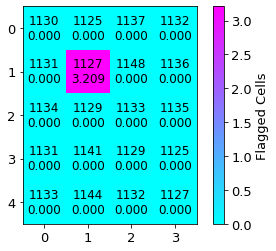

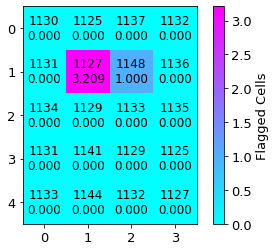

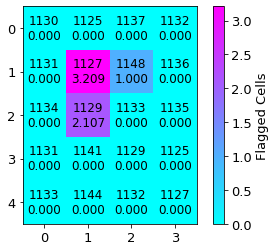

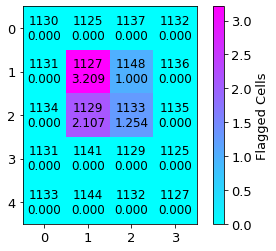

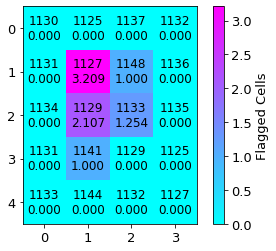

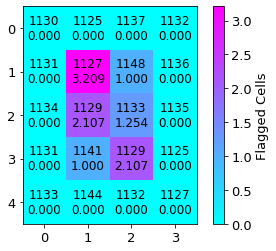

In [37]:
#this is the test array
elevation_array = np.array([
    [1130, 1125, 1137, 1132],
    [1131, 1127, 1148, 1136],
    [1134, 1129, 1133, 1135],
    [1131, 1141, 1129, 1125],   
    [1133, 1144, 1132, 1127],
])
rows,cols=elevation_array.shape

#fig, ax = plt.subplots(figsize=(8, 6))
# plt.imshow(elevation_array, cmap='viridis')
# for i in range(0, rows): 
#     for j in range(0, cols):
#         # Annotate the cell with the value from the array, or use a symbol conditionally
#         value = elevation_array[i, j]
#         index= f'({i}, {j})'
#         c = elevation_array[i,j] if value >0 else elevation_array[i,j]  # Example condition
#         ax.text(j, i, f'{c}\n{index}', va='center', ha='center', fontsize=12, color="black")
# plt.title("Elevation Array with Cell Coordinates")
# Execute the fixed visualization
# visualize_propagated_flagging(elevation_array) 
# fig, ax = plt.subplots(figsize=(8, 6))
# Static_contributing_area_array=calculate_contributingArea_for_cell(elevation_array, 1)
# plt.imshow(Static_contributing_area_array, cmap='viridis')
# for i in range(0, rows): 
#     for j in range(0, cols):
#         # Annotate the cell with the value from the array, or use a symbol conditionally
#         value = Static_contributing_area_array[i, j]
#         c = elevation_array[i,j] if value >0 else elevation_array[i,j]  # Example condition
#         ax.text(j, i, f'{c}\n{value:.1f}', va='center', ha='center', fontsize=12, color="black")
# plt.title("Contributing Area for each cell")
# twi_array,contributing_area_array,average_slope_array = Calculate_TWI_corrected_SlopeWeight(elevation_array, 1)
# plt.imshow(twi_array, cmap='viridis')
# for i in range(0, rows): 
#     for j in range(0, cols):
#         # Annotate the cell with the value from the array, or use a symbol conditionally
#         value = twi_array[i, j]
#         print("the twi value is: ",value)
#         c = elevation_array[i,j]if value >=0.0 else elevation_array[i,j]  # Example condition
#         ax.text(j, i, f'{c}\n{value:.1f}', va='center', ha='center', fontsize=12, color="black")
# plt.title("twi_array for each cell")
# downwardSlope = calculateDownwardSlope(elevation_array, 1)
# plt.imshow(downwardSlope, cmap='viridis')
# for i in range(0, rows): 
#     for j in range(0, cols):
#         # Annotate the cell with the value from the array, or use a symbol conditionally
#         value = downwardSlope[i, j]
#         #print("the twi value is: ",value)
#         c = elevation_array[i,j]if value >=0.0 else elevation_array[i,j]  # Example condition
#         ax.text(j, i, f'{c}\n{value:.1f}', va='center', ha='center', fontsize=12, color="black")
# plt.title("downwardslope length")
visualize_propagated_flagging(elevation_array) 
#visualize_propagated_flagging(elevation_array_Transposed)


Text(0.5, 1.0, 'twi_array')

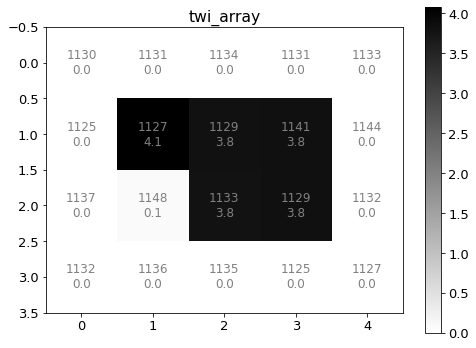

In [38]:
#Testing with the tranposed version of the test array
elevation_array_Transposed=elevation_array.T
rows,cols=elevation_array_Transposed.shape
twi_array,weightSlopeArray=Calculate_TWI_extendedSlope(elevation_array_Transposed, 1)
fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(twi_array,cmap="binary")
plt.colorbar()
plt.title("TWI_array")
for i in range(0, rows): 
    for j in range(0, cols):
        # Annotate the cell with the value from the array, or use a symbol conditionally
        value = twi_array[i, j]
        #print("the twi value is: ",value)
        c = elevation_array_Transposed[i,j]if value >=0.0 else elevation_array_Transposed[i,j]  # Example condition
        ax.text(j, i, f'{c}\n{value:.1f}', va='center', ha='center', fontsize=12, color="grey")
plt.title("twi_array")

Text(0.5, 1.0, 'twi_array')

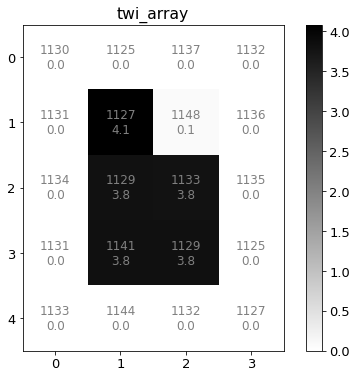

In [39]:

#the twi calculated using the elevation array example
twi_array,weightSlopeArray=Calculate_TWI_extendedSlope(elevation_array, 1)
rows,cols=elevation_array.shape
fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(twi_array,cmap="binary")
plt.colorbar()
plt.title("TWI_array")
for i in range(0, rows): 
    for j in range(0, cols):
        # Annotate the cell with the value from the array, or use a symbol conditionally
        value = twi_array[i, j]
        #print("the twi value is: ",value)
        c = elevation_array[i,j]if value >=0.0 else elevation_array[i,j]  # Example condition
        ax.text(j, i, f'{c}\n{value:.1f}', va='center', ha='center', fontsize=12, color="grey")
plt.title("twi_array")

Text(0.5, 1.0, 'slope')

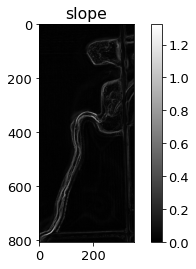

In [42]:
import math
downwardslope=calculateDownwardSlope(elevationArrayDict["imgAcreMergedUSGSVectorHighRes"], resDict["imgAcreMergedUSGSVectorHighRes"])

plt.imshow(downwardslope,cmap="binary_r")   
plt.colorbar()
plt.title("slope")


In [43]:
twi_array,weightSlopeArray  = Calculate_TWI_extendedSlope(elevationArrayDict["imgAcreMergedUSGSVectorLowerRes"], resDict["imgAcreMergedUSGSVectorLowerRes"])
# twi_array,weightSlopeArray  = Calculate_TWI_extendedSlope(elevationArrayDict["imgAcreMergedUSGSVectorLowRes"], resDict["imgAcreMergedUSGSVectorLowRes"])
# twi_array,weightSlopeArray  = Calculate_TWI_extendedSlope(elevationArrayDict["imgAcreMergedUSGSVectorHighRes"], resDict["imgAcreMergedUSGSVectorHighRes"])



Text(0.5, 1.0, 'contributing_area_array')

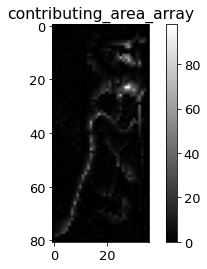

In [44]:

plt.imshow(weightSlopeArray,cmap="binary_r")   
plt.colorbar()
rows, cols = weightSlopeArray.shape
plt.title("contributing_area_array")



Text(0.5, 1.0, 'TWI_array')

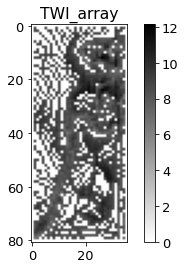

In [45]:
plt.imshow(twi_array,cmap="binary")
plt.colorbar()
plt.title("TWI_array")